## Aim

To investigate the plausibility of a balance between constant gain of resistance and purifying selection to maintain coexistence of sensitive and resistant strains in <i>S. pneunoniae</i>.

## Objectives

* Develop a multi-serotype model of transmission of sensitive and resistant strains of pneumococcus, incorporating dynamics of resistance genes 
* Identify the parameter region of "rate of gain of resistance" that would permit the maintenance of sensitive and resistant strains at observed resistance levels
* Investigate patterns in resistance frequency by serotype under this model

## Tasks

* Use example code to set up the multi-serotype model
* Parameterise using existing literature
* Plot resistance frequency across parameter space (e.g. rate of gain of resistance, resistance cost, treatment rate)
* Identify values of rate of gain of resistance that maintain observed levels of resistance (how does this depend on treatment rate?)
* Comment (via comparison to data on rates of HGT, transformation, mutation) on how realistic this range is
* Plot resistance frequency by serotype under the model (for a suitable value of gain-of-resistance rate)
* Comment on how realistic these patterns are in comparison to observed data

## Things in this notebook (07/07/25)


* Flow diagram: a quick demonstration of the model we have in mind as a diagram
* Model equations: a first-parse at the model equations we have in mind
* Data set: data from a carriage survey that can be used to show a target resistance frequency and serotype-specific patterns in resistance

## Extensions:

* How do the results change if gain of resistance is totally or partially dependent on treatment?
* Fit the model to ECDC data to get a tighter estimate on needed range in rate of gain of resistance, taking between-country variation in treatment and resistance frequency into account

### Example code: single serotype model
I have two bits of code that will be useful for getting started. Firstly, below is a single-serotype version of the proposed model. In this model, we track the fraction of the population that are uncolonised (X), or colonised by a sensitive (S) or resistant strain (R).

$$
    X = 1 - (S + R)\\
    \frac{dS}{dt} = \beta X S - \mu S - \tau S - \gamma S\\
    \frac{dR}{dt} = (1-c) \beta X R - \mu R + \gamma S
$$

Where $\beta$ is the transmission rate, $\mu$ is the clearance rate, $\tau$ is the treatment rate, and $\gamma$ is the rate of gain of antibiotic resistance. The flow diagram for this model:

![singleserotypeRGmodel](img/flowdiagST.png)

And the code for this model:

In [23]:
# A single-serotype model with rate of gain of resistance
using DifferentialEquations, Plots
function RGmod(du, u, p, t)
    
    #assign parameters to local names to make easier to read
    β, μ, c, τ, γ = p

    X = 1 - sum(u) #proportion of population uncolonised
    S, R = u

    du[1] = β*X*S - μ*S - τ*S - γ*S #changes to Sd
    du[2] = (1-c)*β*X*R - μ*R + γ*S #changes to Rd

end

RGmod (generic function with 1 method)

Next we specify the parameters and initial conditions:

In [24]:
#Parameters
β = 1.5
μ = 1/12
c = 0.3
τ = 0.01
γ = 0.01
p = [β, μ, c, τ, γ] #collect parameters in a vector

#Initial conditions
u0 = [0.1,0.1]

2-element Vector{Float64}:
 0.1
 0.1

Next we solve the model numerically and plot:

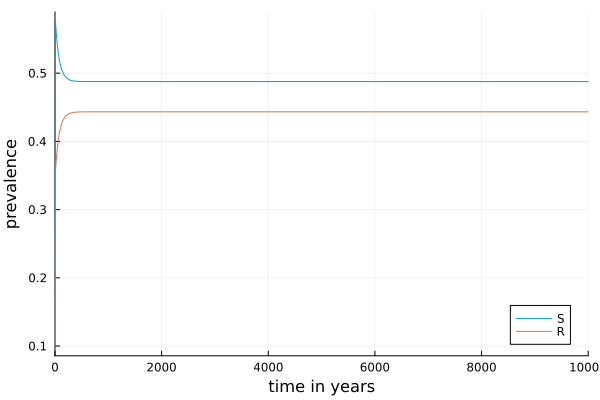

In [25]:
probRG = ODEProblem(RGmod, u0, (0.,10000.), p)
solRG = solve(probRG)
plot(solRG, xlab = "time in years", ylab = "prevalence", labels = ["S" "R"])

#### Example code: multi serotype model
Secondly, code that runs a multi-serotype model that is very similar to the multi-serotype gain of resistance model we are aiming for. This needs adapting but should hopefully get you started. Please find more detail and model equations in this paper, page 11: https://doi.org/10.1126/scitranslmed.aaz8690

In [26]:
#The model
function pdmod(du, u, p, t)
    
    #assign parameters to local names to make easier to read
    β, c, τ, a, D = p[1:5]
    D = Int64(D)
    mu = p[6:(5+D)]

    X = 1 - sum(u) #proportion of population uncolonised

    for d in 1:D #loop through serotypes
        
        Sd, Rd = [u[d], u[D+d]] #total individuals colonised by S and R versions of ST (easier to read)
        
        qd = (1 - (Sd+Rd)/(1 - X) + 1/D)^a #NFDS term

        du[d] = qd*β*X*Sd - mu[d]*Sd - τ*Sd #changes to Sd
        du[D+d] = qd*(1-c)*β*X*Rd - mu[d]*Rd #changes to Rd

    end

end

pdmod (generic function with 1 method)

Under this model, each serotype has the same transmission rate and a different duration of carriage. We calculate clearance rates (which determine duration of carriage) with the below function. This will need updating with a suitable function to transmission rates for each serotype.

In [27]:
function carrdur(μ, δ, D)
    mud = zeros(D)
    for i in 1:D
       mud[i] = μ * (1 + δ * (2 * ((i-1) / (D-1)) - 1) )
    end
    return mud
end

carrdur (generic function with 1 method)

Next we set up the parameters and initial conditions.

In [28]:
#Parameter set up
β = 1.5 #transmission rate
c = 0.6 #resistance cost
τ = 0.1 #treatment rate
a = 2. #diversifying selection strength
D = 10 #number of serotypes

μaverage = 1/12
mus = carrdur(μaverage, 0.3, D) #calculate the carriage durations for each serotype
p = vcat([β, c, τ, a, D], mus) #group parameter values

#Initial conditions set up
u0 = zeros(D*2) .+ 0.01

20-element Vector{Float64}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

Finally, we solve numerically and plot the results.

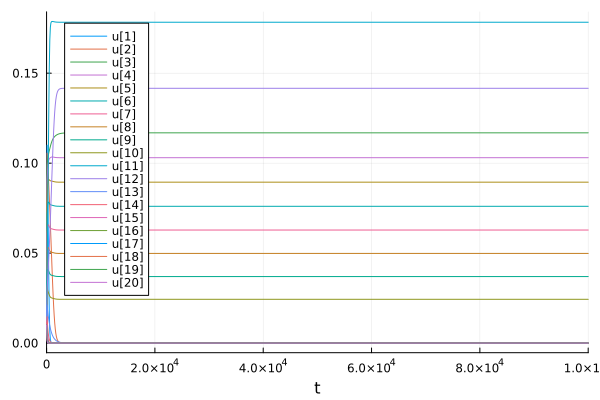

In [29]:
#Model set up
prob = ODEProblem(pdmod, u0, (0.,100000.), p)

#Numerically solve the model and plot
sol = solve(prob)
plot(sol)

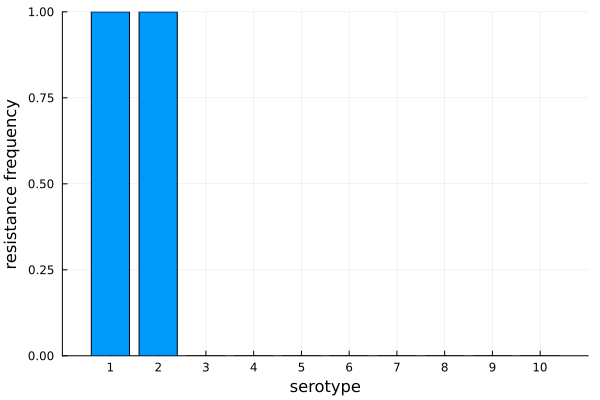

In [30]:
#Now plot resistance frequency by serotype
Ss = sol(100000.)[1:D]
Rs = sol(100000.)[D+1:D*2]
resistancefrequency = Rs ./ (Ss .+ Rs)
bar(resistancefrequency, 
    xlab = "serotype", ylab = "resistance frequency",
    labels = nothing, xticks = [1:1:10;])